In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation
from keras.initializers import RandomUniform, Initializer, Constant
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
# from keras.layers import Dense, Activation
# from keras.layers import Activation
# from keras.optimizers import RMSprop


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
tf.debugging.set_log_device_placement(False)

In [4]:
PATH_TO_DB = '/content/drive/MyDrive/BMM'

Классы

In [5]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None, **kwargs):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

In [6]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x, *args, **kwargs):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [7]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=1)
        km.fit(self.X)
        return km.cluster_centers_


In [8]:
df_th = pd.read_csv(join(PATH_TO_DB,'BD_platelets_regular.csv'), sep=';')
df_th

r  eps       n  beta              0            0.5              1  \
0       0.5  0.1  1.3725    40      25.301178      25.209944      24.938040   
1       0.5  0.1  1.3725    42      25.253750      25.164614      24.898931   
2       0.5  0.1  1.3725    44      25.202293      25.115267      24.855852   
3       0.5  0.1  1.3725    46      25.143423      25.058531      24.805452   
4       0.5  0.1  1.3725    48      25.076042      24.993305      24.746632   
...     ...  ...     ...   ...            ...            ...            ...   
196139  2.1  1.0  1.3875    82  214711.812500  212251.640600  205016.031300   
196140  2.1  1.0  1.3875    84  214710.484400  212250.328100  205014.765600   
196141  2.1  1.0  1.3875    86  214710.375000  212250.218800  205014.671900   
196142  2.1  1.0  1.3875    88  214711.218800  212251.046900  205015.484400   
196143  2.1  1.0  1.3875    90  214711.406300  212251.234400  205015.656300   

                  1.5              2            2.5  ...      85.5        86  \
0           24.490799      23.876934      23.108286  ...  0.035687  0.040932   
1           24.461840      23.861731      23.110008  ...  0.110150  0.120814   
2           24.428991      23.842764      23.108150  ...  0.219127  0.230691   
3           24.388945      23.816780      23.099533  ...  0.305602  0.309963   
4           24.340595      23.782681      23.083057  ...  0.312300  0.304946   
...               ...            ...            ...  ...       ...       ...   
196139  193427.546900  178150.890600  160037.921900  ...  1.374523  1.331677   
196140  193426.375000  178149.843800  160037.015600  ...  1.377804  1.336296   
196141  193426.281300  178149.765600  160036.968800  ...  1.384726  1.344976   
196142  193427.046900  178150.500000  160037.640600  ...  1.388198  1.349743   
196143  193427.218800  178150.656300  160037.781300  ...  1.388530  1.350548   

            86.5        87      87.5        88      88.5        89      89.5  \
0       0.046830  0.053408  0.060684  0.068672  0.077375  0.086786  0.096886   
1       0.131986  0.143610  0.155616  0.167922  0.180437  0.193053  0.205656   
2       0.241920  0.252689  0.262871  0.272336  0.280954  0.288599  0.295148   
3       0.313069  0.314847  0.315234  0.314183  0.311665  0.307667  0.302198   
4       0.296285  0.286385  0.275334  0.263235  0.250206  0.236381  0.221905   
...          ...       ...       ...       ...       ...       ...       ...   
196139  1.215894  1.043869  0.838637  0.626118  0.431531  0.276193  0.175054   
196140  1.221435  1.049784  0.844330  0.631035  0.435245  0.278462  0.175858   
196141  1.231294  1.060079  0.854240  0.639758  0.442089  0.282927  0.177689   
196142  1.237083  1.066495  0.860799  0.645923  0.447320  0.286726  0.179647   
196143  1.238340  1.068137  0.862710  0.647944  0.449255  0.288354  0.180742   

              90  
0       0.107647  
1       0.218120  
2       0.300487  
3       0.295287  
4       0.206933  
...          ...  
196139  0.135262  
196140  0.134800  
196141  0.134010  
196142  0.133848  
196143  0.134204  

[196144 rows x 185 columns]

In [9]:
columns_to_keep = ['r', 'eps', 'n', 'beta'] + [str(column) for column in range(10, 70)]
df_th = df_th[columns_to_keep]

In [10]:
X = df_th.iloc[:, 4:]

In [11]:
y = df_th[['r', 'eps', 'n', 'beta']]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
Xvse_scaled = scaler_X.fit_transform(X)

# # Создание экземпляра MinMaxScaler для нормализации y
scaler_y = MinMaxScaler()
y_scaled= scaler_y.fit_transform(y)

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [14]:
X_train, X_test, y_train, y_test = train_test_split(Xvse_scaled , y_scaled, test_size=0.25, shuffle=True)

In [15]:
len(X_train)

147108

In [16]:
# Весовая функция
def weight_formula(to_weight, θ):
    return to_weight*((1/θ)*np.exp(-2*(np.log(θ/54))**2))

θ = [str(column) for column in range(10, 70)]
θ = list(map(float, θ))
vectorized = np.vectorize(weight_formula)

In [17]:
# Применение функции к массивам
X_train_weighted = np.array(vectorized(X_train, θ))
X_test_weighted = np.array(vectorized(X_test, θ))

In [29]:
rbflayer = RBFLayer(256,
                    initializer=InitCentersKMeans(X_train),
                    betas=3.0,
                    input_shape=(60,))

In [30]:
with tf.device('/gpu:0'):
  model = Sequential()
  model.add(rbflayer)
  model.add(Dense(256,
                    input_shape=(60,)))
  model.add(Dense(256))
  model.add(Dense(4))
  model.add(Activation('relu'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 1905.9855208188053.
Iteration 1, inertia 1561.7585283857848.
Iteration 2, inertia 1519.1475790830705.
Iteration 3, inertia 1501.349274221841.
Iteration 4, inertia 1490.1122293689068.
Iteration 5, inertia 1481.7433200049645.
Iteration 6, inertia 1475.5233980842688.
Iteration 7, inertia 1470.5784587783362.
Iteration 8, inertia 1466.323462856413.
Iteration 9, inertia 1462.7170581975365.
Iteration 10, inertia 1460.0255280428983.
Iteration 11, inertia 1458.0190979708373.
Iteration 12, inertia 1456.167176044107.
Iteration 13, inertia 1454.5939201919828.
Iteration 14, inertia 1453.1981123033056.
Iteration 15, inertia 1451.8893772160916.
Iteration 16, inertia 1450.9017137969804.
Iteration 17, inertia 1450.0867777938383.
Iteration 18, inertia 1449.2149084678904.
Iteration 19, inertia 1448.1967119158453.
Iteration 20, inertia 1447.3765557454594.
Iteration 21, inertia 1446.722633583137.
Iteration 22, inertia 1446.147539856528.
Iteration 23, inertia 144

In [31]:
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine_proximity'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_2 (RBFLayer)      (None, 256)               15616     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
Total params: 148,228
Trainable params: 148,228
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
len(model.weights)

8

In [33]:
with tf.device('/gpu:0'):
  history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
2299/2299 [==============================] - 15s 6ms/step - loss: 0.0639 - mse: 0.0639 - mae: 0.1866 - mape: 31600458.0000 - cosine_proximity: 0.8922 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1656 - val_mape: 34604904.0000 - val_cosine_proximity: 0.9100
Epoch 2/100
2299/2299 [==============================] - 14s 6ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1634 - mape: 31363848.0000 - cosine_proximity: 0.9147 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1598 - val_mape: 30773340.0000 - val_cosine_proximity: 0.9182
Epoch 3/100
2299/2299 [==============================] - 13s 6ms/step - loss: 0.0470 - mse: 0.0470 - mae: 0.1569 - mape: 30609572.0000 - cosine_proximity: 0.9180 - val_loss: 0.0466 - val_mse: 0.0466 - val_mae: 0.1564 - val_mape: 31547672.0000 - val_cosine_proximity: 0.9180
Epoch 4/100
2299/2299 [==============================] - 13s 6ms/step - loss: 0.0458 - mse: 0.0458 - mae: 0.1539 - mape: 30151064.0000 - cosine_proximity: 0.9196 - val_loss: 0.04

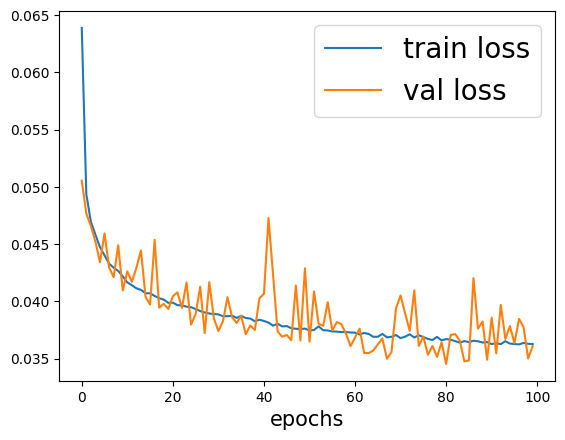

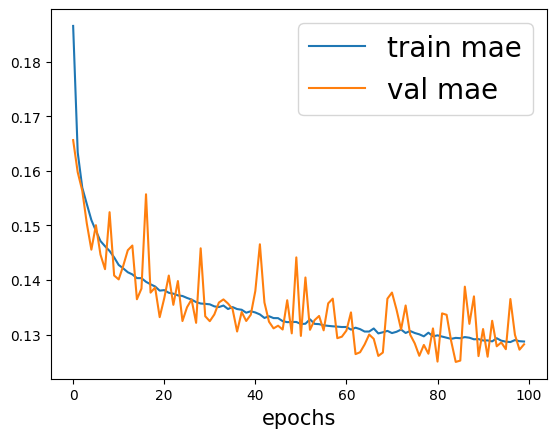

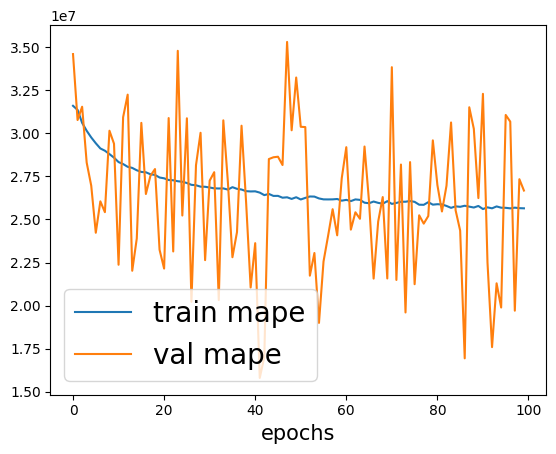

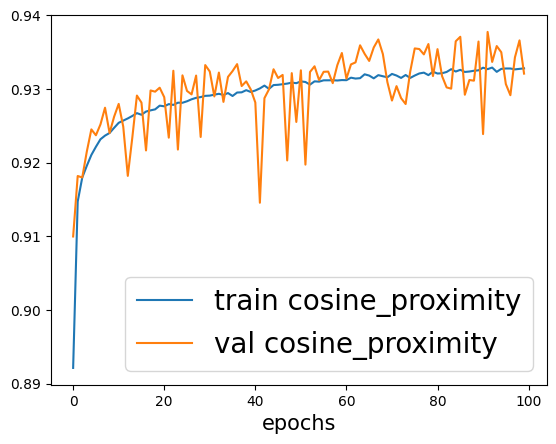

In [34]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['mape'], label='train mape')
plt.plot(history.history['val_mape'], label='val mape')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

plt.plot(history.history['cosine_proximity'], label='train cosine_proximity')
plt.plot(history.history['val_cosine_proximity'], label='val cosine_proximity')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [47]:
import timeit
start_time = timeit.default_timer()
preds = model.predict(X_test)
time_1 = timeit.default_timer() - start_time
print("Общее время: " + str(time_1) + " мс")
print("Время на частицу: " + str(time_1/len(X_test)*1000) + " мс")

1533/1533 [==============================] - 3s 2ms/step
Общее время: 5.2027305739998155 мс
Время на частицу: 0.10610022379475927 мс


In [48]:
y_test_r = y_test[:, 0]
preds_r = preds[:, 0]

y_test_eps = y_test[:, 1]
preds_eps = preds[:, 1]

y_test_n = y_test[:, 2]
preds_n = preds[:, 2]

y_test_beta = y_test[:, 3]
preds_beta = preds[:, 3]

In [49]:
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error
from math import sqrt

print()
print(
f'r2 = {r2_score(y_test, preds):.2f} MedAE = {median_absolute_error(y_test, preds):.2f}',
f'r2 = {r2_score(y_test, preds):.2f} MSE = {mean_squared_error(y_test, preds):.2f}',sep='\n')

print()
print('r')
print(
f'r2 = {r2_score(y_test_r, preds_r):.3f} MedAE = {median_absolute_error(y_test_r, preds_r):.3f}',
f'r2 = {r2_score(y_test_r, preds_r):.3f} MSE = {mean_squared_error(y_test_r, preds_r):.3f}',sep='\n')

print()
print('eps')
print(
f'r2 = {r2_score(y_test_eps, preds_eps):.3f} MedAE = {median_absolute_error(y_test_eps, preds_eps):.3f}',
f'r2 = {r2_score(y_test_eps, preds_eps):.3f} MSE = {mean_squared_error(y_test_eps, preds_eps):.3f}',sep='\n')

print()
print('n')
print(
f'r2 = {r2_score(y_test_n, preds_n):.3f} MedAE = {median_absolute_error(y_test_n, preds_n):.3f}',
f'r2 = {r2_score(y_test_n, preds_n):.3f} MSE = {mean_squared_error(y_test_n, preds_n):.3f}',sep='\n')

print()
print('beta')
print(
f'r2 = {r2_score(y_test_beta, preds_beta):.3f} MedAE = {median_absolute_error(y_test_beta, preds_beta):.3f}',
f'r2 = {r2_score(y_test_beta, preds_beta):.3f} MSE = {mean_squared_error(y_test_beta, preds_beta):.3f}',sep='\n')


r2 = 0.69 MedAE = 0.09
r2 = 0.69 MSE = 0.04

r
r2 = 0.855 MedAE = 0.060
r2 = 0.855 MSE = 0.013

eps
r2 = 0.828 MedAE = 0.050
r2 = 0.828 MSE = 0.015

n
r2 = 0.309 MedAE = 0.203
r2 = 0.309 MSE = 0.096

beta
r2 = 0.774 MedAE = 0.056
r2 = 0.774 MSE = 0.020


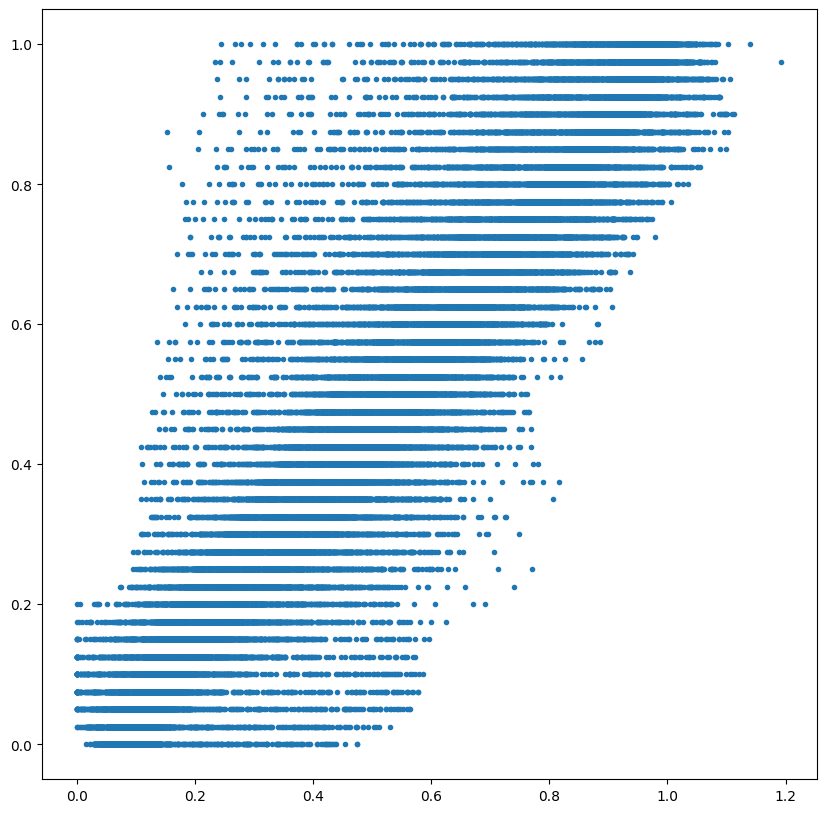

In [37]:
plt.figure(figsize=(10, 10))
plt.plot(preds[:, 0], y_test[:,0], '.')

In [38]:
def predict_regr_plot(y_test, y_pred, params, sup_title):
    N = len(params)

    plt.figure(figsize=(40, 40))
    #plt.suptitle(sup_title)
    for i in range(N):
        for j in range(N):
            if i == j:
                plt.subplot(N, N, i * N + j + 1)
                plt.title("Корреляционный график")
                plt.xlabel(str(params[i]) + ' Тестовые')
                plt.ylabel(str(params[i]) + ' Предсказанные')

                plt.plot(y_test[:, i], y_pred[:, i], '*')

                #plt.legend()
            else:
                plt.subplot(N, N, i * N + j + 1)
                plt.title("Сравнительная карта параметров")
                plt.xlabel(params[i])
                plt.ylabel(params[j])

                plt.plot(y_test[:, i], y_test[:, j], '*', label="Тест")
                plt.plot(y_pred[:, i], y_pred[:, j], '.', label="Предсказание")
                plt.legend()
    plt.show()

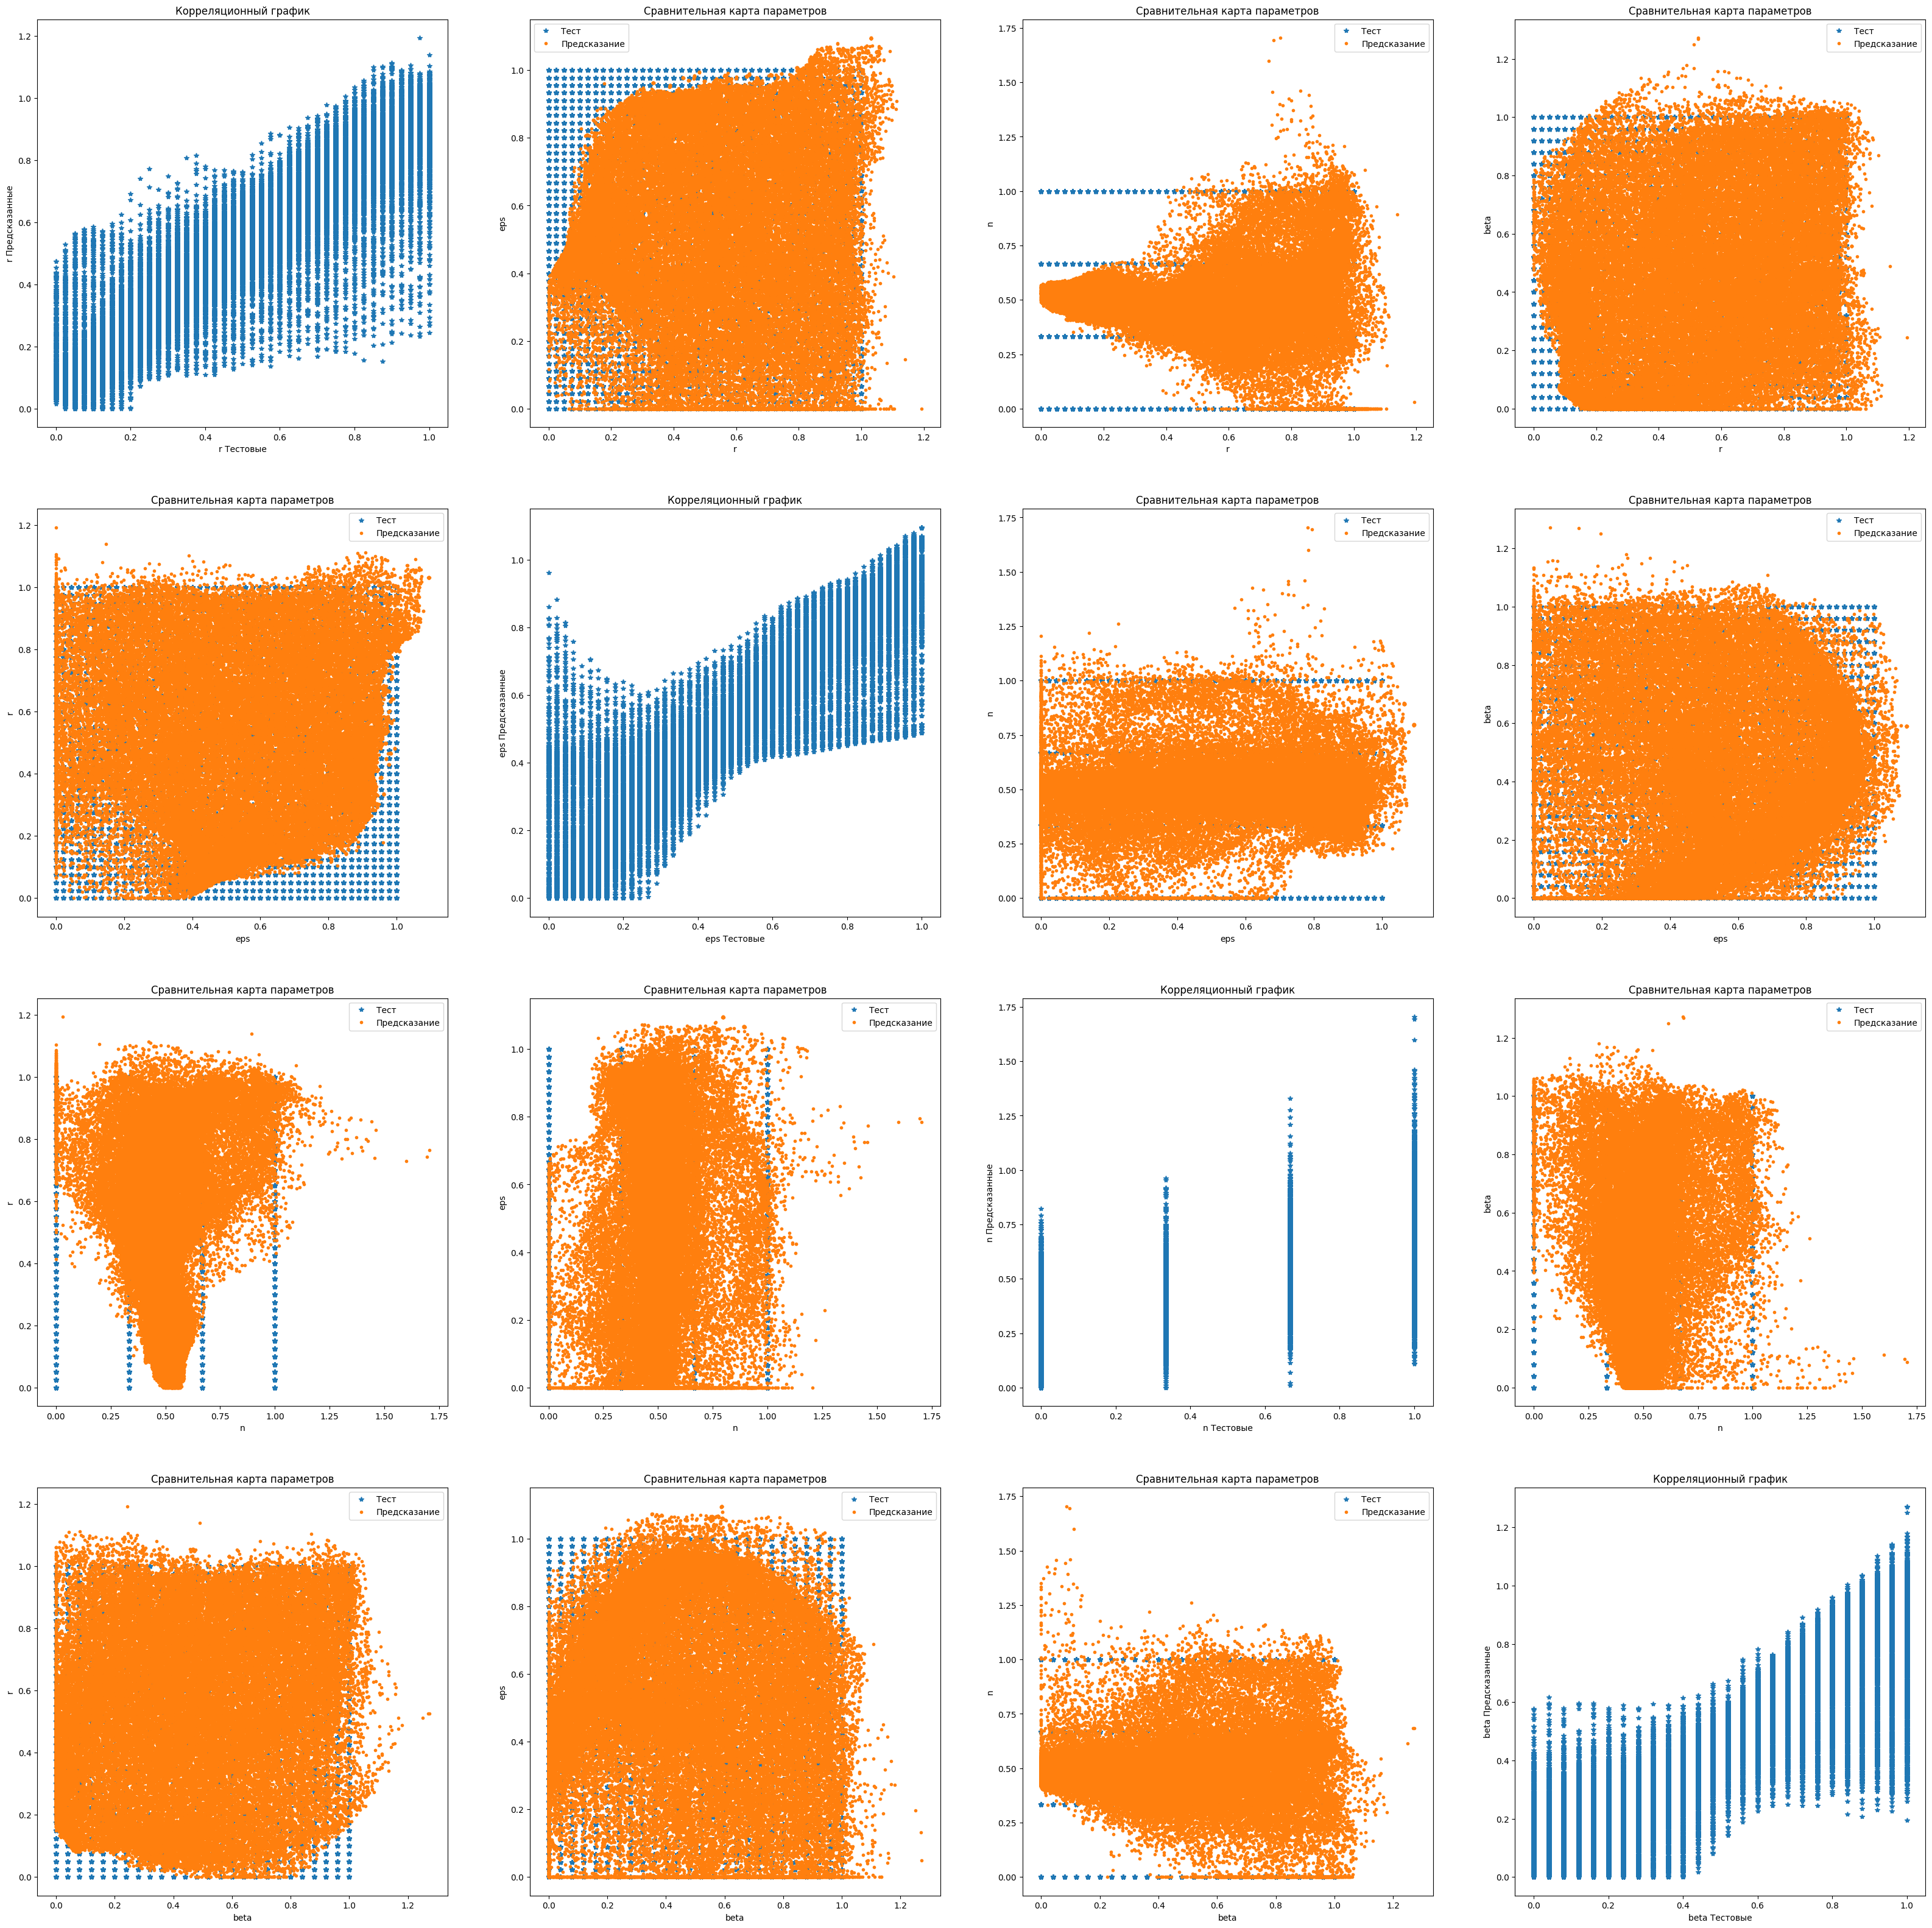

In [39]:
predict_regr_plot(y_test, preds, ['r', 'eps', 'n', 'beta'], '')

In [40]:
Y_unscaled = scaler_y.inverse_transform(y_test)
preds_unscaled = scaler_y.inverse_transform(preds)

In [41]:
len(Y_unscaled)

49036

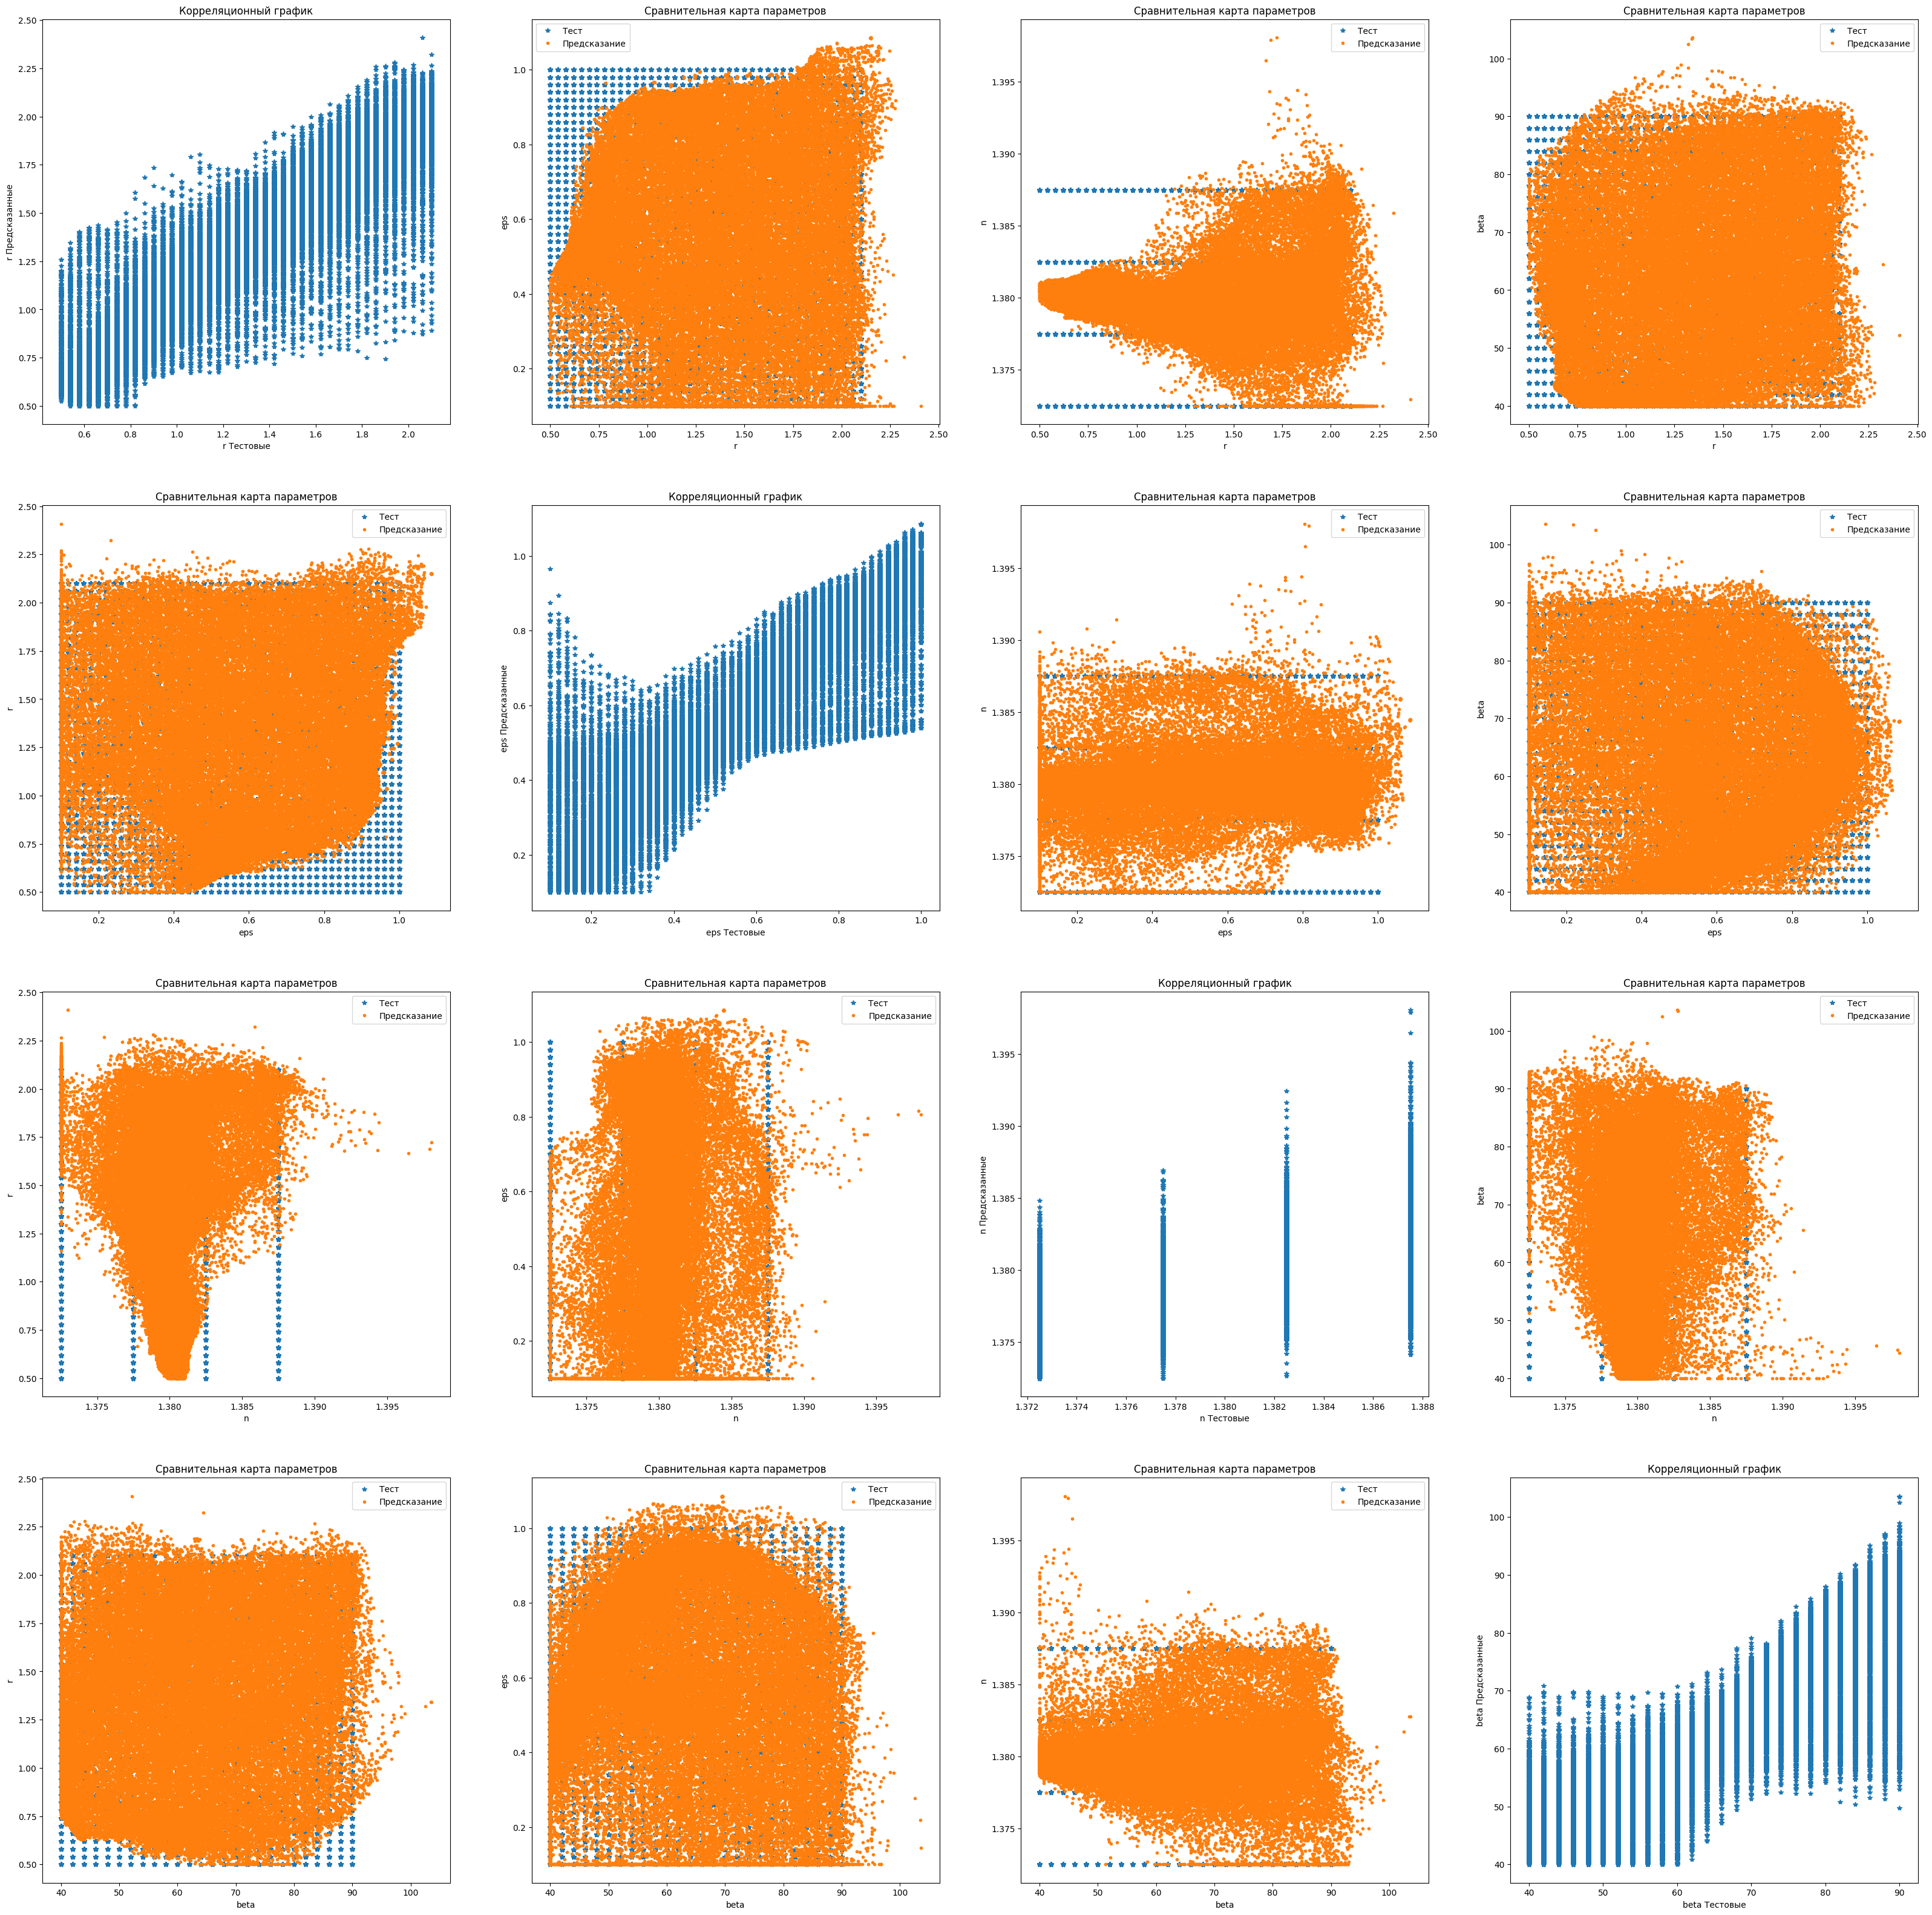

In [42]:
predict_regr_plot(Y_unscaled, preds_unscaled, ['r', 'eps', 'n', 'beta'], '')

In [45]:
def predict_regr_plot(y_test, y_pred, params, sup_title):
    N = len(params)

    plt.figure(figsize=(40, 10))
    #plt.suptitle(sup_title)
    for i in range(N):
        # for j in range(N):
            # if i == j:
            plt.subplot(1, N, i + 1)
            plt.title(str(params[i]), fontsize=30)
            plt.xlabel(str(params[i]) + ' Тестовые')
            plt.ylabel(str(params[i]) + ' Предсказанные')

            plt.plot(y_test[:, i], y_pred[:, i], '*')

                #plt.legend()
            # else:
            #     plt.subplot(N, N, i * N + j + 1)
            #     plt.title("Сравнительная карта параметров")
            #     plt.xlabel(params[i])
            #     plt.ylabel(params[j])

            #     plt.plot(y_test[:, i], y_test[:, j], '*', label="Тест")
            #     plt.plot(y_pred[:, i], y_pred[:, j], '.', label="Предсказание")
            #     plt.legend()
    plt.show()

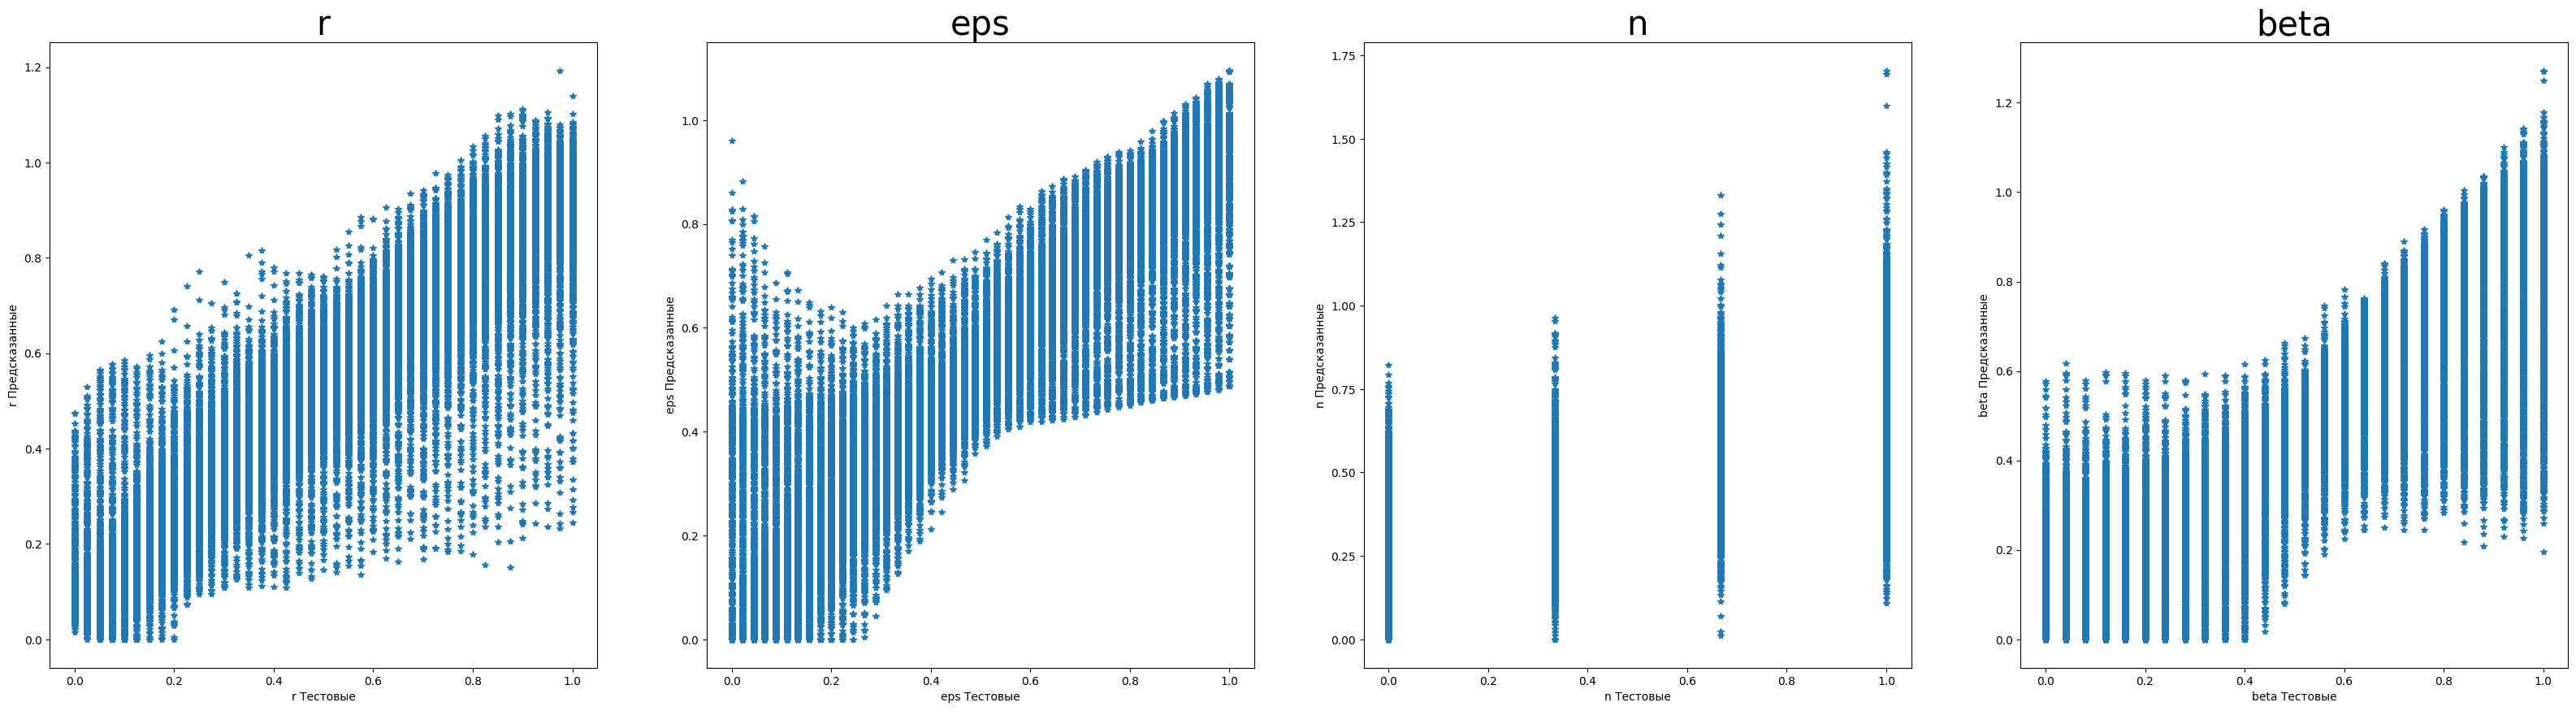

In [46]:
predict_regr_plot(y_test, preds, ['r', 'eps', 'n', 'beta'], '')